In [13]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

graph = load_graph('output_graph.pb')
# with tf.gfile.FastGFile('output_graph.pb') as f:
#     graph_def = tf.GraphDef()
#     graph_def.ParseFromString(f.read())
#     _ = tf.import_graph_def(graph_def, name='')
# with tf.Session() as sess: 
#     saver = tf.train.import_meta_graph('output_graph.pb')
# #     saver.restore(sess, tf.train.latest_checkpoint('models/detect'))

#     graph = tf.get_default_graph()
#     x = graph.get_tensor_by_name('x_value:0')
#     predictions = graph.get_tensor_by_name('predictions:0')
#     probabilities = graph.get_tensor_by_name('Softmax:0')
#     res = process_image(test_img_1, sess, x, predictions, probabilities)
    
# plt.imshow(res)

In [15]:
def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label

labels = load_labels('output_labels.txt')
print(labels)

['green', 'red', 'yellow', 'none']


[ 0.19809237  0.62816608  0.16608556  0.00765597]
red 0.628166
green 0.198092
yellow 0.166086
none 0.00765597


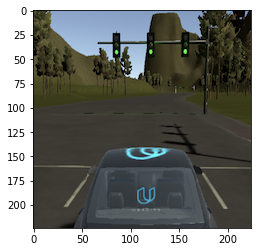

In [28]:
def read_tensor_from_image_file(file_name, input_height=299, input_width=299,
				input_mean=0, input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
  else:
    image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0);
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

file_name = "tmp/1.png"

input_height = 224
input_width = 224
input_mean = 156
input_std = 156

input_layer = "input"
output_layer = "final_result"

input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name);
output_operation = graph.get_operation_by_name(output_name);

t = read_tensor_from_image_file(file_name,
                                  input_height=input_height,
                                  input_width=input_width,
                                  input_mean=input_mean,
                                  input_std=input_std)

with tf.Session(graph=graph) as sess:
    results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: t})

results = np.squeeze(results)
top_k = results.argsort()[-5:][::-1]
print(results)
for i in top_k:
    print(labels[i], results[i])
    
img = cv2.imread(file_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)